# Trabalho Prático 1 de Introdução à Computação Visual

**Aluno 1:** Pedro de Oliveira Guedes

**Aluno 2:** Gabriel XXXXXXXX

O presente trabalho tem por objetivo a implementação de um algoritmo de compressão, buscando exercitar os conceitos estudados em sala de aula durante a matéria de Introdução à Computação Visual. Somente serão trabalhadas imagens em tons de cinza.

O algoritmo escolhido foi o **JPEG**, que é um dos algoritmos de compressão de imagens mais utilizados no mundo. O JPEG é um **algoritmo de compressão COM perdas**, ou seja, a imagem comprimida não é exatamente igual à original.

De forma resumida, o algoritmo JPEG funciona da seguinte forma:

1. Divisão da imagem de entrada completa em blocos de 8x8 pixels.

2. Aplicação de transformada em cada um dos blocos.
    * A transformada utilizada é a ***Discrete Cosine Transform (DCT)***, ou Transformada Discreta do Cosseno.

    * A justificativa para a utilização da DCT em oposição à ***DFT (Discrete Fourier Transform)*** será explicada em mais detalhes posteriormente.

3. Divisão do bloco transformado pela chamada "**Matriz de Quantização**", que também é uma matriz 8x8 com coeficientes pré-definidos que, quanto maior forem, mais perda de informação haverá.

4. Codificação por entropia (**Comprimento de Corridas**) dos coeficientes resultantes da etapa anterior, gerando uma tabela de codificação.

Para complementar a compressão, também será feita a compressão por **Codificação de Huffman**, que explora a **Redundância de Codificação** das imagens e tem o potencial de aumentar a taxa de compressão final, sem adicionar mais perdas de qualidade, já que essa é uma estratégia de **Compressão sem Perdas**. Essa técnica será aplicada após a codificação por comprimento de corridas ao fim do algoritmo JPEG.

Para a realização deste trabalho, será utilizada a linguagem de programação Python, com auxílio das bibliotecas NumPy, para lidar com as manipulações matemáticas, e OpenCV, para lidar com a leitura e escrita de imagens.

## Principais bibliotecas utilizadas
Para a implementação do algoritmo, serão utilizadas três dependências principais:

1. **NumPy**: Biblioteca para manipulação de arrays multidimensionais e realização de operações matemáticas.

2. **Matplotlib**: Biblioteca para visualização de gráficos e imagens.

3. **OpenCV**: Biblioteca para manipulação de imagens.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as opencv

## Funções auxiliares
Ao longo da implementação, serão utilizadas algumas funções auxiliares, como de visualização das imagens, para facilitar a compreensão do código. Essas funções serão definidas a seguir.

### Visualização de imagens
O método `imshow` da biblioteca do OpenCV está sofrendo conflitos quando o código é executado em arquivos Jupyter Notebook, que é o caso deste trabalho.

Para contornar esse problema, será definida uma função auxiliar `show_images` que utiliza a biblioteca Matplotlib para exibir as imagens.

Essa função receberá um dicionário, cujas chaves são os títulos das imagens e os valores são as imagens em si. As imagens recebidas serão exibidas em um grid, facilitando a visualização e a comparação entre elas.

In [2]:
def show_images(images: dict[str, opencv.typing.MatLike]) -> None:
    fig = plt.figure(figsize=(20, 10))
    for i, (name, image) in enumerate(images.items()):
        ax = fig.add_subplot(1, len(images), i + 1)
        ax.set_title(name, fontsize=20)
        ax.axis("off")
        ax.imshow(image, cmap="gray")

    plt.show()

### Adição de bordas para imagens
Em alguns casos pode ser necessário adicionar bordas a uma imagem para o processamento. Um exemplo disso é a primeira etapa do algoritmo JPEG, onde a divisão da imagem em blocos de 8x8 pixels pode ser feita em uma imagem original cujas dimensões não são múltiplas de 8.

Para contornar esse problema, será definida uma função `add_padding` que adiciona bordas à imagem de acordo com a dimensão atual e a dimensão desejada, dividindo a diferença entre as dimensões igualmente entre os lados superior, inferior, esquerdo e direito.

A biblioteca `math` será utilizada para arredondar os valores resultantes da divisão.

In [3]:
import math

def pad_image(
    image: opencv.typing.MatLike,
    final_height: int,
    final_width: int,
    border_type: int = opencv.BORDER_CONSTANT,
) -> opencv.typing.MatLike:
    height, width = image.shape

    if height >= final_height and width >= final_width:
        return image
    
    top = math.ceil((final_height - height) / 2)
    bottom = math.floor((final_height - height) / 2)
    left = math.ceil((final_width - width) / 2)
    right = math.floor((final_width - width) / 2)

    return opencv.copyMakeBorder(
        src=image,
        top=top,
        bottom=bottom,
        left=left,
        right=right,
        borderType=border_type,
        dst=None,
    )

### Calculo de qualidade da compressão
Após a compressão das imagens, é necessário calcular alguns coeficientes que indicam a qualidade. Serão utilizadas duas métricas principais:
- **Root Mean Square Error (RMSE):** O **Raiz do Erro Quadrático Médio** calcula a diferença entre os pixels da imagem comprimida em relação aos pixels da imagem original, aumentando quadraticamente todas as diferenças. Dessa forma, erros maiores são punidos com maior severidade.

- **Peak Signal to Noise Ratio (PSNR):** A **Taxa de Pico de Sinal para Ruído** é uma métrica que avalia o nível de degradação da imagem após a compressão, utilizando não o **RMSE**, mas sim o **MSE** que é apenas **Erro Quadrático Médio**. A unidade padrão dessa medida é de **decibéis (db)**.

Como podem ocorrer erros de conversão devido à constante manipulação de números do tipo `float`, as métricas serão arredondadas para utilizar no máximo 5 casas decimais.

In [4]:
def mse(compressed: opencv.typing.MatLike, original: opencv.typing.MatLike) -> float:
    mse_value = np.mean((compressed - original) ** 2)
    return round(mse_value, 5)

def rmse(compressed: opencv.typing.MatLike, original: opencv.typing.MatLike) -> float:
    rmse_value = np.sqrt(mse(compressed, original))
    return round(rmse_value, 5)

def psnr(compressed: opencv.typing.MatLike, original: opencv.typing.MatLike) -> float:
    psnr_value = 20 * np.log10(255 / rmse(compressed, original))
    return round(psnr_value, 5)

## Processo de compressão JPEG
Nesta seção, será detalhado o processo de compressão de imagens utilizando o algoritmo JPEG, exemplificando cada uma das etapas com algoritmos e imagens dos resultados preliminares.

### 1. Divisão da imagem em blocos de 8x8 pixels
A primeira etapa do algoritmo JPEG consiste em dividir a imagem de entrada em blocos de 8x8 pixels, que serão processados individualmente ao longo do algoritmo. Embora essa divisão seja costumeiramente feita a cada etapa do algoritmo de compressão JPEG, é importante criar uma função que faça a separação desses blocos para facilitar a implementação do caminhamento zigue-zague, utilizado para a compressão dos blocos por comprimento de corrida.

In [5]:
def divide_image_in_blocks(image: opencv.typing.MatLike, block_size: int = 8) -> list[opencv.typing.MatLike]:
    blocks = []
    rows, cols = image.shape
    if rows % block_size != 0 or cols % block_size != 0:
        image = pad_image(
            image=image,
            final_height=math.ceil(rows / block_size) * block_size,
            final_width=math.ceil(cols / block_size) * block_size,
        )

    for i in range(0, rows, block_size):
        for j in range(0, cols, block_size):
            block = image[i:i + block_size, j:j + block_size]
            blocks.append(block)

    return blocks

#### 1.1. Reconstrução da imagem dividida em blocos
Após o processamento dos blocos 8x8, é necessário reconstruir a imagem original.

In [6]:
def reconstruct_image_from_blocks(
    blocks: list[opencv.typing.MatLike],
    image_shape: tuple[int, int],
    add_grid: bool = False,
) -> opencv.typing.MatLike:
    rows, cols = image_shape

    block_rows, block_cols = blocks[0].shape

    image = np.zeros((rows, cols), dtype=np.float32)
    block_index = 0
    for i in range(0, rows, block_rows):
        for j in range(0, cols, block_cols):
            block = blocks[block_index]
            image[i:i + block_rows, j:j + block_cols] = block
            block_index += 1

    if add_grid:
        for i in range(0, rows, block_rows):
            image = opencv.line(image, (0, i), (cols, i), 0, 1)
        for j in range(0, cols, block_cols):
            image = opencv.line(image, (j, 0), (j, rows), 0, 1)

    return image

#### 1.2. Exemplo
Para exemplificar e testar a divisão da imagem em blocos, será utilizada a imagem `lena512.pgm` presente na pasta `images` deste repositório.

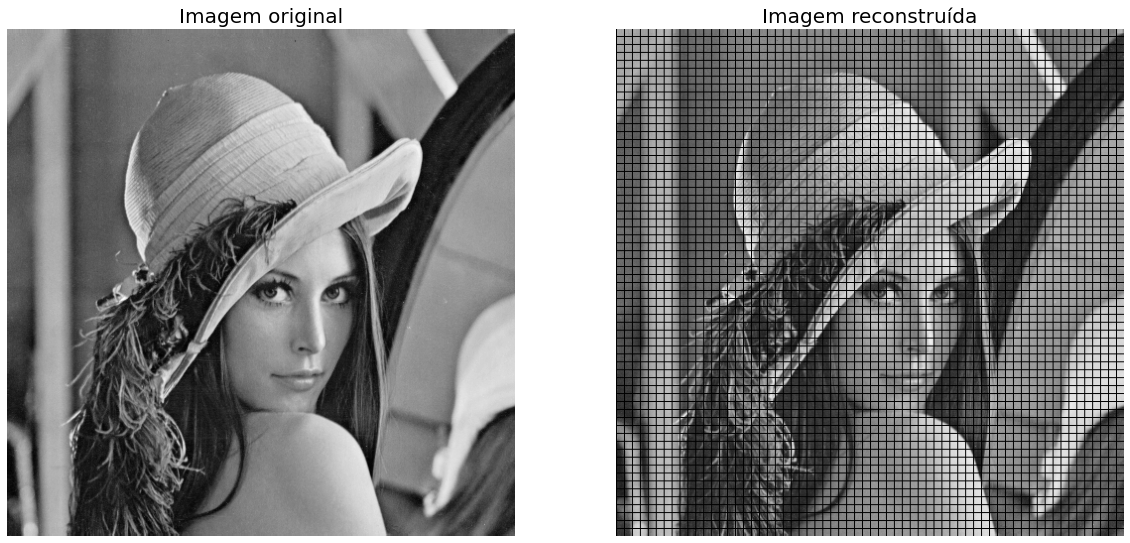

In [7]:
def test_block_division_and_reconstruction():
    image = opencv.imread("images/lena512.pgm", opencv.IMREAD_GRAYSCALE)

    blocks = divide_image_in_blocks(image)

    reconstructed_image = reconstruct_image_from_blocks(blocks, image.shape)

    assert mse(reconstructed_image, image) == 0

    show_images({"Imagem original": image, "Imagem reconstruída": reconstruct_image_from_blocks(blocks, image.shape, add_grid=True)})

test_block_division_and_reconstruction()

### 2. Aplicação da Transformada Discreta do Cosseno (DCT)
A escolha da DCT em detrimento da DFT se dá pelo agrupamento de coeficientes de alta frequência no canto superior esquerdo da matriz resultante, enquanto os valores de baixa frequência se concentram no canto inferior direito.

Com isso, somado à ordenação zigue-zague dos coeficientes, é possível obter uma grande sequência de zeros, facilitando a compressão por entropia.

Antes de fazer a transformada, é feita a normalização dos valores da matriz de entrada, subtraindo 128 de cada pixel.

In [8]:
def apply_dct(image: opencv.typing.MatLike, block_size: int = 8) -> opencv.typing.MatLike:
    image_copy = image.astype(float)
    image_copy = image_copy - 128

    dct_image = np.zeros(image.shape, np.float32)

    for row in range(0, image.shape[0], block_size):
        for col in range(0, image.shape[1], block_size):
            image_block = image_copy[row:row+block_size, col:col+block_size]
            dct_image[row:row+block_size, col:col+block_size] = opencv.dct(image_block)

    return dct_image

#### 2.1. Reversão da DCT
Para a descompressão da imagem, é necessário reverter a DCT aplicada.

In [9]:
def revert_dct(dct_image: opencv.typing.MatLike, block_size: int = 8) -> opencv.typing.MatLike:
    reverted_image = np.zeros(dct_image.shape, np.float32)

    for row in range(0, dct_image.shape[0], block_size):
        for col in range(0, dct_image.shape[1], block_size):
            dct_block = dct_image[row:row+block_size, col:col+block_size]
            reverted_image[row:row+block_size, col:col+block_size] = opencv.idct(dct_block)
    
    reverted_image = reverted_image + 128
    
    return reverted_image

#### 2.2. Exemplo
Para uma visualização mais clara dos resultados, a célula a seguir faz a transformada do primeiro bloco 8x8 da imagem `lena512.pgm` e a sua reconstrução.

Como a DCT é um processo totalmente reversível, é verificado se a imagem reconstruída é igual à original com a métrica **RMSE**, que deve ser igual a zero.

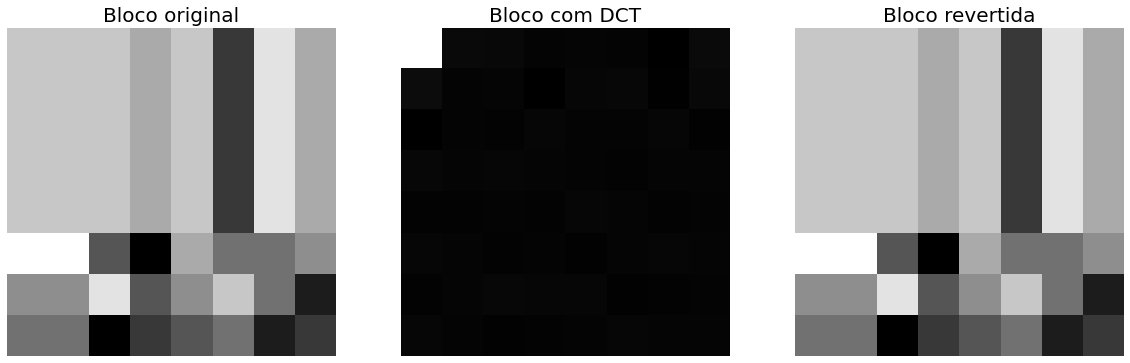

In [10]:
def test_apply_and_revert_dct_first_block():
    image = opencv.imread("images/lena512.pgm", opencv.IMREAD_GRAYSCALE)[0:8, 0:8]

    dct_image = apply_dct(image)
    reverted_image = revert_dct(dct_image)

    assert rmse(reverted_image, image) == 0

    show_images({"Bloco original": image, "Bloco com DCT": dct_image, "Bloco revertida": reverted_image})

test_apply_and_revert_dct_first_block()

Note como, assim como foi previamente comentado, os valores de baixa frequência se concentram no canto inferior direito da matriz resultante, sendo basicamente uma grande sequência de zeros.

A célula abaixo mostra a imagem original, a transformada DCT completa e a imagem reconstruída a partir da DCT, com o cálculo do RMSE entre a imagem original e a imagem reconstruída.

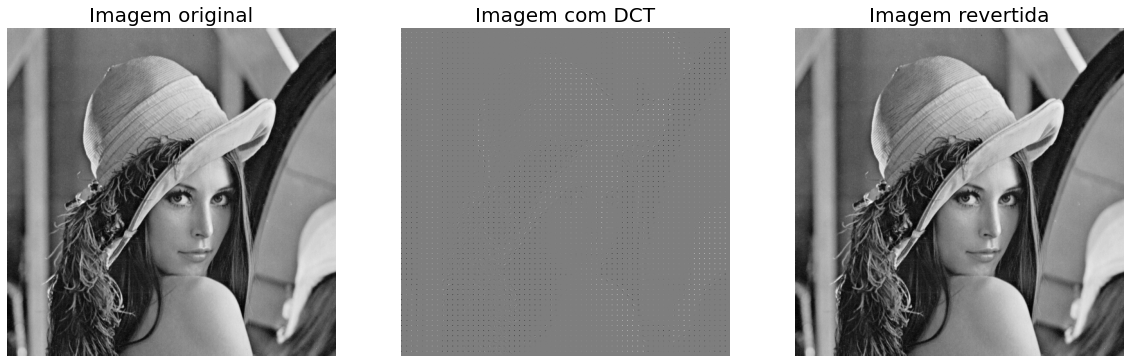

In [11]:
def test_apply_and_revert_dct_full_image():
    image = opencv.imread("images/lena512.pgm", opencv.IMREAD_GRAYSCALE)

    dct_image = apply_dct(image)
    reverted_image = revert_dct(dct_image)

    assert rmse(reverted_image, image) == 0

    show_images({"Imagem original": image, "Imagem com DCT": dct_image, "Imagem revertida": reverted_image})

test_apply_and_revert_dct_full_image()

### 3. Quantização
A quantização consiste na divisão dos coeficientes resultantes da DCT por uma matriz e arredondamento dos resultados, buscando reduzir a quantidade de informação a ser armazenada.

A matriz de quantização utilizada será a padrão de luminância, definida pelos criadores do algoritmo JPEG. Para referência, é possível verificá-la na publicação [***INFORMATION TECHNOLOGY – DIGITAL COMPRESSION AND CODING OF CONTINUOUS-TONE STILL IMAGES – REQUIREMENTS AND GUIDELINES***](https://www.w3.org/Graphics/JPEG/itu-t81.pdf), mais especificamente no anexo K, página 143.

Vale ressaltar que a quantização não deve ser feita na posição (0, 0) da matriz, pois esse coeficiente é o `DC coefficient`, que é o valor médio de todos os pixels do bloco. No caso de quantização dessa posição, a qualidade da imagem seria muito prejudicada.

In [12]:
quantization_matrix = np.matrix([
    [16, 11, 10, 16, 24, 40, 51, 61], 
    [12, 12, 14, 19, 26, 58, 60, 55],
    [14, 13, 16, 24, 40, 57, 69, 56],
    [14, 17, 22, 29, 51, 87, 80, 62],
    [18, 22, 37, 56, 68, 109, 103, 77],
    [24, 35, 55, 64, 81, 104, 113, 92],
    [49, 64, 78, 87, 103, 121, 120, 101],
    [72, 92, 95, 98, 112, 100, 103, 99],
])

def apply_quantization(dct_image: opencv.typing.MatLike, block_size: int = 8) -> opencv.typing.MatLike:
    quantized_image = np.zeros(dct_image.shape, np.float32)

    for row in range(0, dct_image.shape[0], block_size):
        for col in range(0, dct_image.shape[1], block_size):
            dct_block = dct_image[row:row+block_size, col:col+block_size]
            dc_coefficient = dct_block[0, 0]

            quantized_block = np.round(np.divide(dct_block, quantization_matrix))
            
            quantized_block[0, 0] = dc_coefficient
            quantized_image[row:row+block_size, col:col+block_size] = quantized_block

    return quantized_image

#### 3.1. Reversão da quantização
Para a descompressão da imagem, é necessário reverter a quantização aplicada.

Da mesma forma que foi feita no processo de quantização, a reversão da quantização não deve ser feita no `DC coefficient`.

In [13]:
def revert_quantization(quantized_image: opencv.typing.MatLike, block_size: int = 8) -> opencv.typing.MatLike:
    reverted_image = np.zeros(quantized_image.shape, np.float32)

    for row in range(0, quantized_image.shape[0], block_size):
        for col in range(0, quantized_image.shape[1], block_size):
            quantized_block = quantized_image[row:row+block_size, col:col+block_size]
            dc_coefficient = quantized_block[0, 0]

            reverted_block = np.multiply(quantized_block, quantization_matrix)

            reverted_block[0, 0] = dc_coefficient
            reverted_image[row:row+block_size, col:col+block_size] = reverted_block

    return reverted_image

#### 3.2. Exemplo
Como o processo de quantização leva a perdas, não é possível reverter a imagem exatamente igual à original. Portanto, a célula a seguir apenas ilustra o processo de quantização e reversão da quantização na imagem completa.

MSE: 16.74374008178711
RMSE: 4.091909885406494
PSNR: 35.89228


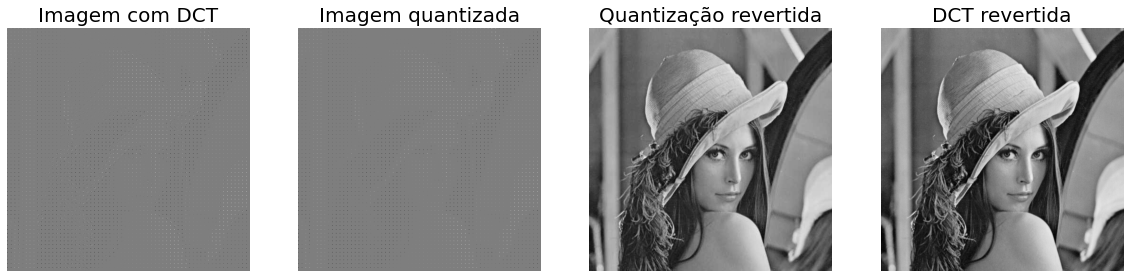

In [14]:
def show_quantization():
    image = opencv.imread("images/lena512.pgm", opencv.IMREAD_GRAYSCALE)

    dct_image = apply_dct(image)
    quantized_image = apply_quantization(dct_image)
    reverted_image = revert_quantization(quantized_image)
    reverted_image = revert_dct(reverted_image)

    print(f"MSE: {mse(reverted_image, image)}")
    print(f"RMSE: {rmse(reverted_image, image)}")
    print(f"PSNR: {psnr(reverted_image, image)}")

    show_images({"Imagem com DCT": dct_image, "Imagem quantizada": quantized_image, 
                 "Quantização revertida": reverted_image, "DCT revertida": revert_dct(dct_image)})

show_quantization()

### 4. Codificação dos coeficientes
A codificação dos coeficientes quantizados se baseia na **redundância interpixel**, mais especificamente na grande quantidade de níveis de cinza similares que tendem a aparecer próximos uns aos outros após a transformada e quantização.

Para isso, será utilizada a codificação por **comprimento de corridas**, onde os blocos serão substituídos por sequências de pares (valor, quantidade de repetições). Para que a codificação seja feita de forma ótima, aproveitando do padrão de organização dos valores trazida pela transformada discreta do cosseno, é necessário que o caminhamento pelos coeficientes da matriz seja feito em zigue-zague.

Note que a entrada dessa função é uma lista de blocos, sendo necessária a utilização da função `divide_image_in_blocks` definida na primeira etapa deste documento.

In [15]:
def run_lenght_encode(blocks: list[opencv.typing.MatLike]) -> list[list[tuple[int, int]]]:
    max_lines, max_columns = blocks[0].shape

    encoded_blocks = []
    for block in blocks:
        encoded_block = []
        previous_value = block[0, 0]
        count = 1
        line, column = 0, 1
        line_increment, column_increment = 1, -1
        while True:
            current_value = block[line, column]
            if current_value == previous_value:
                count += 1
            else:
                encoded_block.append((previous_value, count))
                previous_value = current_value
                count = 1
            
            if line == max_lines - 1 and column == max_columns - 1:
                encoded_block.append((previous_value, count))
                break

            line += line_increment
            column += column_increment

            if line < 0 or line >= max_lines or column < 0 or column >= max_columns:
                line_increment, column_increment = column_increment, line_increment # Swap values
            
            if column < 0 and line < max_lines:
                column = 0
            if line < 0 and column < max_columns:
                line = 0
            if line >= max_lines:
                line = max_lines - 1
                column += 2
            if column >= max_columns and line < max_lines:
                column = max_columns - 1
                line += 2
        
        encoded_blocks.append(encoded_block)

    return encoded_blocks

#### 4.1. Reversão da codificação
A reversão da codificação consiste em percorrer os blocos 8x8 da imagem em ordenação zigue-zague, copiando os níveis de cinza para a matriz de saída de acordo com a quantidade de repetições.

In [16]:
def run_lenght_decode(
    encoded_blocks: list[list[tuple[int, int]]],
    block_size: int = 8,
) -> list[opencv.typing.MatLike]:
    decoded_blocks = []
    for encoded_block in encoded_blocks:
        decoded_block = np.zeros((block_size, block_size), dtype=np.float32)

        line, column = 0, 0
        line_increment, column_increment = 1, -1
        for encoded_values in encoded_block:
            encoded_value, count = encoded_values
            if line == column == 0:
                decoded_block[line, column] = encoded_value
                column += 1
                count -= 1

            for _ in range(count):
                decoded_block[line, column] = encoded_value

                if line == block_size - 1 and column == block_size - 1:
                    break

                line += line_increment
                column += column_increment

                if line < 0 or line >= block_size or column < 0 or column >= block_size:
                    line_increment, column_increment = column_increment, line_increment # Swap values
                
                if column < 0 and line < block_size:
                    column = 0
                if line < 0 and column < block_size:
                    line = 0
                if line >= block_size:
                    line = block_size - 1
                    column += 2
                if column >= block_size and line < block_size:
                    column = block_size - 1
                    line += 2

        decoded_blocks.append(decoded_block)

    return decoded_blocks

#### 4.2. Exemplo
As células a seguir mostram a execução da codificação por comprimento de corridas e a reversão da mesma.

Inicialmente, será feita em uma matriz artificial, criada especialmente para ter valores de 0 a 63 em ordem zigue-zague, mostrando que a codificação e a reversão estão funcionando corretamente.

In [17]:
def test_rle_encode_and_decode():
    # Arrange
    block = np.matrix([
        [ 0,  1,  5,  6, 14, 15, 27, 28],
        [ 2,  4,  7, 13, 16, 26, 29, 42],
        [ 3,  8, 12, 17, 25, 30, 41, 43],
        [ 9, 11, 18, 24, 31, 40, 44, 53],
        [10, 19, 23, 32, 39, 45, 52, 54],
        [20, 22, 33, 38, 46, 51, 55, 60],
        [21, 34, 37, 47, 50, 56, 59, 61],
        [35, 36, 48, 49, 57, 58, 62, 63],
    ])

    # Act
    encoded = run_lenght_encode([block])
    decoded = run_lenght_decode(encoded)

    # Assert
    assert len(encoded) == 1
    assert len(decoded) == 1

    assert len(encoded[0]) == 64
    assert len(decoded[0].flatten()) == 64

    curr_value = 0
    for value, count in encoded[0]:
        assert count == 1
        assert value == curr_value

        curr_value += 1
    assert (decoded[0] == block).all()

    print(f"{encoded[0]}\n\n{decoded[0]}")

test_rle_encode_and_decode()

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1)]

[[ 0.  1.  5.  6. 14. 15. 27. 28.]
 [ 2.  4.  7. 13. 16. 26. 29. 42.]
 [ 3.  8. 12. 17. 25. 30. 41. 43.]
 [ 9. 11. 18. 24. 31. 40. 44. 53.]
 [10. 19. 23. 32. 39. 45. 52. 54.]
 [20. 22. 33. 38. 46. 51. 55. 60.]
 [21. 34. 37. 47. 50. 56. 59. 61.]
 [35. 36. 48. 49. 57. 58. 62. 63.]]


Perceba agora o mesmo teste sendo feito, mas dessa vez com a imagem original.

In [18]:
def test_rle_encode_and_decode_original_image() -> None:
    image = opencv.imread("images/lena512.pgm", opencv.IMREAD_GRAYSCALE)

    dct_image = apply_dct(image)

    quantized_image = apply_quantization(dct_image)
    quantized_blocks = divide_image_in_blocks(quantized_image)

    encoded = run_lenght_encode(quantized_blocks)
    decoded = run_lenght_decode(encoded)

    assert len(decoded) == len(quantized_blocks)
    for block_index in range(len(decoded)):
        assert (decoded[block_index] == quantized_blocks[block_index]).all()
    
    print(f"{encoded[0]}\n\n{decoded[0]}")

test_rle_encode_and_decode_original_image()

[(259.5, 1), (0.0, 1), (1.0, 1), (-0.0, 61)]

[[259.5   0.   -0.   -0.   -0.   -0.   -0.   -0. ]
 [  1.   -0.   -0.   -0.   -0.   -0.   -0.   -0. ]
 [ -0.   -0.   -0.   -0.   -0.   -0.   -0.   -0. ]
 [ -0.   -0.   -0.   -0.   -0.   -0.   -0.   -0. ]
 [ -0.   -0.   -0.   -0.   -0.   -0.   -0.   -0. ]
 [ -0.   -0.   -0.   -0.   -0.   -0.   -0.   -0. ]
 [ -0.   -0.   -0.   -0.   -0.   -0.   -0.   -0. ]
 [ -0.   -0.   -0.   -0.   -0.   -0.   -0.   -0. ]]


## Codificação de Huffman
A codificação de Huffman será aplicada após a codificação por comprimento de corridas, buscando aumentar a taxa de compressão final.

Ela consiste nas seguintes etapas:
1. Criação de uma tabela de frequência dos símbolos.

2. Criação de uma árvore de Huffman a partir da tabela de frequência.

3. Criação de uma tabela de códigos a partir da árvore de Huffman.

4. Codificação da mensagem original utilizando a tabela de códigos.

### 1. Criação da tabela de frequência
A tabela de frequência é um dicionário onde as chaves são os símbolos e os valores são as frequências de cada símbolo.

In [19]:
def get_frequency_table(rle_blocks: list[list[tuple[int, int]]]) -> dict[int, int]:
    frequency_table = {}
    for rle_block in rle_blocks:
        for value, count in rle_block:
            if value in frequency_table:
                frequency_table[value] += count
            else:
                frequency_table[value] = count

    return frequency_table

#### 1.1. Exemplo
Para exemplificar a criação da tabela de frequência, será criada uma lista de blocos codificados por comprimento de corridas e a tabela de frequência correspondente.

In [20]:
def test_get_frequency_table():
    rle_blocks = [
        [(0, 1), (2, 3), (1, 2)],
        [(1, 1), (0, 3), (2, 2)],
    ]

    frequency_table = get_frequency_table(rle_blocks)

    assert frequency_table[0] == 4
    assert frequency_table[1] == 3
    assert frequency_table[2] == 5

test_get_frequency_table()

### 2. Criação da árvore de Huffman
A árvore de Huffman é uma árvore binária onde as folhas são os símbolos, ou níveis de cinza, da imagem. O caminhamento na árvore é feito da raiz até a folha, determinando o código binário de cada símbolo, onde cada caminho para a esquerda é representado pelo bit 0 e cada caminho para a direita é representado pelo bit 1.

#### 2.1. Nó da árvore de Huffman
A classe `HuffmanNode` representa um nó da árvore de Huffman, contendo um valor, uma frequência e referências para os nós filhos.

In [21]:
class HuffmanNode:
    def __init__(self, value: int, count: int):
        self.value = value
        self.count = count
        self.left = None
        self.right = None

    def __lt__(self, other: "HuffmanNode") -> bool:
        return self.count < other.count

    def __repr__(self) -> str:
        return f"{self.value} ({self.count})"

#### 2.2. Construção da árvore de Huffman
A árvore de Huffman é construída a partir da tabela de frequência, onde os nós são ordenados de acordo com a frequência e os dois nós de menor frequência são combinados em um novo nó, cuja frequência é a soma das frequências dos nós anteriores.

In [22]:
def build_huffman_tree(frequency_table: dict[int, int]) -> HuffmanNode:
    nodes = [HuffmanNode(value, count) for value, count in frequency_table.items()]

    while len(nodes) > 1:
        nodes.sort()

        left = nodes.pop(0)
        right = nodes.pop(0)

        parent = HuffmanNode(None, left.count + right.count)
        parent.left = left
        parent.right = right

        nodes.append(parent)

    return nodes[0] # Root of the tree

#### 2.3. Exemplo
Para exemplificar a construção da árvore de Huffman, será utilizada uma tabela de frequência artificial.

In [23]:
def test_build_huffman_tree():
    frequency_table = {2: 6, 0: 4, 1: 3, 3: 2}

    root = build_huffman_tree(frequency_table)

    assert root.value is None
    assert root.count == 15

    assert root.left.value == 2
    assert root.left.count == 6

    assert root.right.value is None
    assert root.right.count == 9

    root_right = root.right
    assert root_right.left.value == 0
    assert root_right.left.count == 4

    assert root_right.right.value is None
    assert root_right.right.count == 5

    root_right_right = root_right.right
    assert root_right_right.left.value == 3
    assert root_right_right.left.count == 2

    assert root_right_right.right.value == 1
    assert root_right_right.right.count == 3

test_build_huffman_tree()

### 3. Criação da tabela de códigos
Serão geradas duas tabelas:
1. **Tabela de códigos**: Dicionário onde as chaves são os símbolos e os valores são os códigos binários correspondentes.
2. **Tabela de códigos invertida**: Dicionário onde as chaves são os códigos binários e os valores são os símbolos correspondentes.

In [24]:
def build_huffman_tables(node: HuffmanNode, code: str = "") -> tuple[dict[int, str], dict[str, int]]:
    if not node:
        return {}, {}

    if node.value is not None: # Leaf node
        return {node.value: code}, {code: node.value}

    left_table, left_reverse_table = build_huffman_tables(node.left, code + "0")
    right_table, right_reverse_table = build_huffman_tables(node.right, code + "1")

    table = {**left_table, **right_table}
    reverse_table = {**left_reverse_table, **right_reverse_table}

    return table, reverse_table

#### 3.1. Exemplo
Para exemplificar a criação da tabela de códigos, será utilizada a árvore de Huffman construída no exemplo anterior.

In [25]:
def test_build_huffman_table():
    frequency_table = {2: 6, 0: 4, 1: 3, 3: 2}

    root = build_huffman_tree(frequency_table)
    table, reverse_table = build_huffman_tables(root)

    assert table == {2: "0", 0: "10", 3: "110", 1: "111"}
    assert reverse_table == {"0": 2, "10": 0, "110": 3, "111": 1}

test_build_huffman_table()

### 4. Codificação da imagem original
A codificação da imagem original é feita substituindo cada símbolo da tabela de frequência pelo seu código binário correspondente.

In [26]:
def encode_rle_blocks_with_huffman(
    rle_blocks: list[list[tuple[int, int]]],
    huffman_table: dict[int, str],
) -> list[list[tuple[str, int]]]:
    encoded_blocks = []
    for rle_block in rle_blocks:
        encoded_block = []
        for value, count in rle_block:
            encoded_value = huffman_table[value]
            encoded_block.append((encoded_value, count))
        encoded_blocks.append(encoded_block)

    return encoded_blocks

#### 4.1. Decodificação da imagem
A decodificação da imagem comprimida pela codificação Huffman é feita substituindo cada código binário da imagem codificada pela sua representação em níveis de cinza.

In [27]:
def decode_rle_blocks_with_huffman(
    encoded_blocks: list[list[tuple[str, int]]],
    reverse_huffman_table: dict[str, int],
) -> list[list[tuple[int, int]]]:
    decoded_blocks = []
    for encoded_block in encoded_blocks:
        decoded_block = []
        for encoded_value, count in encoded_block:
            value = reverse_huffman_table[encoded_value]
            decoded_block.append((value, count))
        decoded_blocks.append(decoded_block)

    return decoded_blocks

#### 4.2. Exemplo
Para exemplificar a codificação da imagem original, será utilizada a tabela de códigos criada no exemplo anterior.

In [28]:
def test_encode_and_decode_rle_blocks_with_huffman():
    rle_blocks = [
        [(0, 1), (2, 3), (1, 2)],
        [(1, 1), (0, 3), (2, 2)],
    ]

    frequency_table = get_frequency_table(rle_blocks)
    root = build_huffman_tree(frequency_table)
    huffman_table, reverse_huffman_table = build_huffman_tables(root)

    encoded_blocks = encode_rle_blocks_with_huffman(rle_blocks, huffman_table)
    decoded_blocks = decode_rle_blocks_with_huffman(encoded_blocks, reverse_huffman_table)

    assert len(decoded_blocks) == len(rle_blocks)
    for block_index in range(len(decoded_blocks)):
        assert decoded_blocks[block_index] == rle_blocks[block_index]
    
    print(f"RLE blocks: {rle_blocks}\n\nEncoded blocks: {encoded_blocks}\n\nDecoded blocks: {decoded_blocks}")

test_encode_and_decode_rle_blocks_with_huffman()

RLE blocks: [[(0, 1), (2, 3), (1, 2)], [(1, 1), (0, 3), (2, 2)]]

Encoded blocks: [[('11', 1), ('0', 3), ('10', 2)], [('10', 1), ('11', 3), ('0', 2)]]

Decoded blocks: [[(0, 1), (2, 3), (1, 2)], [(1, 1), (0, 3), (2, 2)]]


## Implementação do algoritmo completo
Com todas as etapas do algoritmo JPEG e da codificação de Huffman definidas, é possível implementar os algoritmo completo para compressão de imagens.

### 1. Algoritmo JPEG
Primeiramente, é necessário juntar as etapas do algoritmo JPEG em uma única função, facilitando a utilização.

#### 1.1. Compressão JPEG
A função `compress_jpeg` recebe uma imagem e retorna a lista dos comprimentos de corridas dos blocos da imagem.

In [29]:
def compress_jpeg(image: opencv.typing.MatLike) -> tuple[list[list[tuple[int, int]]]]:
    dct_image = apply_dct(image) # Transform

    quantized_image = apply_quantization(dct_image) # Quantization

    quantized_blocks = divide_image_in_blocks(quantized_image)

    rle_blocks = run_lenght_encode(quantized_blocks) # Run-length encoding

    return rle_blocks

#### 1.2. Descompressão JPEG
A função `decompress_jpeg` recebe a lista dos comprimentos de corrida dos blocos da imagem, juntamente com as dimensões da imagem original, retornando a imagem descomprimida.

In [30]:
def decompress_jpeg(
    rle_blocks: tuple[list[list[tuple[int, int]]]],
    image_shape: tuple[int, int],
) -> opencv.typing.MatLike:
    rle_decoded_blocks = run_lenght_decode(rle_blocks)

    rle_decoded_image = reconstruct_image_from_blocks(rle_decoded_blocks, image_shape)

    reverted_image = revert_quantization(rle_decoded_image) # Revert quantization

    reverted_dct_image = revert_dct(reverted_image) # Revert transform

    return reverted_dct_image

#### 1.3. Exemplo
Para exemplificar a compressão e descompressão JPEG, será utilizada a imagem `lena512.pgm`.

Como a compressão JPEG é com perdas, a imagem reconstruída não será exatamente igual à original, mas será possível calcular o **RMSE** e o **PSNR** para avaliar a qualidade da compressão.

Mean Squared Error: 16.74374008178711
Root Mean Squared Error: 4.091909885406494
Peak Signal-to-Noise Ratio: 35.89228


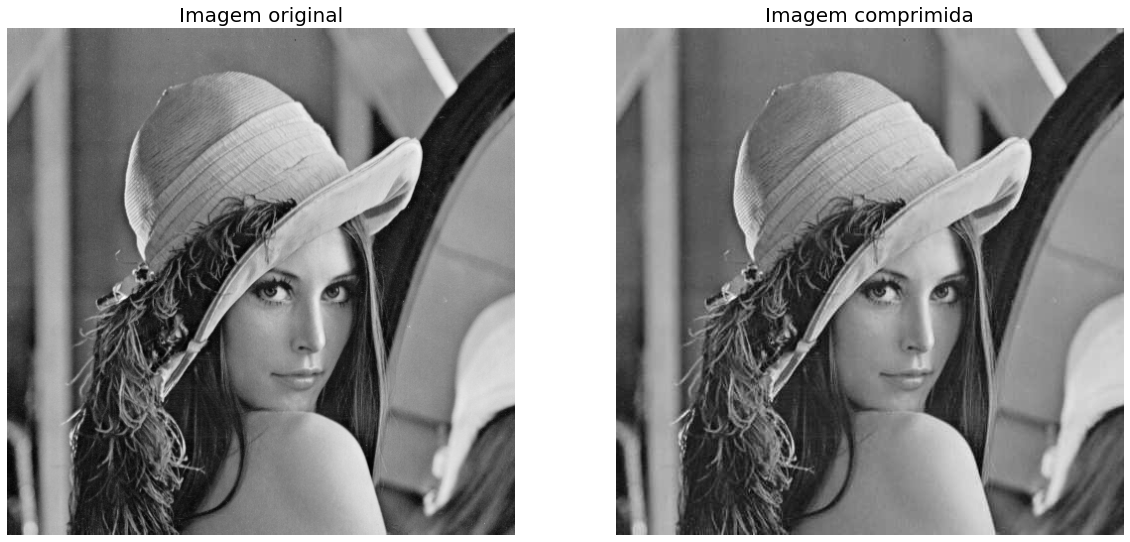

In [31]:
def test_jpeg_compress_and_decompress():
    image = opencv.imread("images/lena512.pgm", opencv.IMREAD_GRAYSCALE)

    rle_blocks = compress_jpeg(image)
    decompressed_image = decompress_jpeg(rle_blocks, image.shape)

    print(f"Mean Squared Error: {mse(decompressed_image, image)}")
    print(f"Root Mean Squared Error: {rmse(decompressed_image, image)}")
    print(f"Peak Signal-to-Noise Ratio: {psnr(decompressed_image, image)}")

    show_images({"Imagem original": image, "Imagem comprimida": decompressed_image})

test_jpeg_compress_and_decompress()

### 2. Algoritmo de Huffman
Nesta seção, será implementada a codificação e decodificação Huffman completas, utilizando as funções definidas anteriormente.

#### 2.1. Tabelas de codificação de Huffman
A função `create_huffman_tables` recebe a lista de blocos codificados por comprimento de corridas e retorna as tabelas de códigos para a codificação e decodificação.

In [32]:
def create_huffman_tables(rle_blocks: list[list[tuple[int, int]]]) -> tuple[dict[int, str], dict[str, int]]:
    frequency_table = get_frequency_table(rle_blocks)

    root = build_huffman_tree(frequency_table)

    huffman_table, reverse_huffman_table = build_huffman_tables(root)

    return huffman_table, reverse_huffman_table

#### 2.2. Codificação e Decodificação de Huffman
Tanto a função de codificação (`encode_rle_blocks_with_huffman`) quanto a de decodificação (`decode_rle_blocks_with_huffman`) já foram definidas anteriormente.

Sendo assim, não é necessário implementá-las novamente.

#### 2.3. Exemplo
Para exemplificar a codificação e decodificação de Huffman, será utilizada a imagem `lena512.pgm` após a compressão JPEG.

In [33]:
def test_full_huffman_encode_and_decode():
    image = opencv.imread("images/lena512.pgm", opencv.IMREAD_GRAYSCALE)

    rle_blocks = compress_jpeg(image)

    huffman_table, reverse_huffman_table = create_huffman_tables(rle_blocks)

    encoded_blocks = encode_rle_blocks_with_huffman(rle_blocks, huffman_table)
    decoded_blocks = decode_rle_blocks_with_huffman(encoded_blocks, reverse_huffman_table)

    assert len(decoded_blocks) == len(rle_blocks)
    for block_index in range(len(decoded_blocks)):
        assert decoded_blocks[block_index] == rle_blocks[block_index]
    
    print(f"RLE blocks: {rle_blocks[0]}\n\nEncoded blocks: {encoded_blocks[0]}\n\nDecoded blocks: {decoded_blocks[0]}")
    # print("\n\nHuffman table:", sorted(reverse_huffman_table.items(), key=lambda x: len(x[0])))

test_full_huffman_encode_and_decode()

RLE blocks: [(259.5, 1), (0.0, 1), (1.0, 1), (-0.0, 61)]

Encoded blocks: [('0110101001101110', 1), ('1', 1), ('001', 1), ('1', 61)]

Decoded blocks: [(259.5, 1), (0.0, 1), (1.0, 1), (0.0, 61)]


### 3. Salvar e carregar imagens comprimidas
Para aproximar o algoritmo implementado de uma aplicação de compressão real, é importante que seja possível salvar e carregar as imagens comprimidas.

Para isso, será definida a extensão `.gbpg` para identificar as imagens comprimidas.

#### 3.1. Salvar imagem comprimida
Após o processo de compressão completo, incluindo tanto a compressão JPEG quanto a codificação de Huffman, a imagem comprimida será salva em um arquivo.

Para realizar essa operação, será utilizada a biblioteca `pickle`, que permite serializar objetos Python e salvá-los em arquivos.

In [34]:
import pickle

def save_compressed_image(file_data: dict[str, any], output_file: str,) -> None:
    with open(output_file, "wb") as file:
        pickle.dump(file_data, file)

#### 3.2. Carregar imagem comprimida
Novamente a biblioteca `pickle` será utilizada, desta vez para carregar e desserializar a imagem comprimida.

In [35]:
def load_compressed_image(input_file: str,) -> dict[str, any]:
    with open(input_file, "rb") as file:
        file_data = pickle.load(file)
    
    return file_data

#### 3.3. Exemplo
Como a função de salvar e carregar imagens comprimidas é agnóstica ao conteúdo da imagem, o exemplo pode ser feito com qualquer dado serializável.

In [36]:
def test_save_and_load_compressed_image():
    mock_img_shape = (8, 8)
    mock_huffman_table = {'0110101001101110': 1, '1': 1, '001': 1, '1': 61}
    mock_rle_blocks = [(259.5, 1), (0.0, 1), (1.0, 1), (-0.0, 61)]

    file_name = "compressed_image.gbpg"

    save_compressed_image(
        file_data={
            "image_shape": mock_img_shape,
            "huffman_table": mock_huffman_table,
            "rle_blocks": mock_rle_blocks,
        },
        output_file=file_name,
    )

    file_data = load_compressed_image(file_name)

    assert file_data["image_shape"] == mock_img_shape
    assert file_data["huffman_table"] == mock_huffman_table
    assert file_data["rle_blocks"] == mock_rle_blocks

test_save_and_load_compressed_image()

### 4. Algoritmo completo
Com todas as etapas do algoritmo JPEG e da codificação de Huffman definidas, é possível implementar o algoritmo completo para compressão e descompressão de imagens, que utiliza ambas as técnicas.

#### 4.1. Compressão completa
A compressão completa consiste em aplicar o algoritmo JPEG e a codificação de Huffman em uma imagem, salvando o resultado em um arquivo.

In [37]:
def full_compression_algorithm(image_path: str, output_file: str) -> None:
    image = opencv.imread(image_path, opencv.IMREAD_GRAYSCALE)

    rle_blocks = compress_jpeg(image)

    huffman_table, reverse_huffman_table = create_huffman_tables(rle_blocks)

    encoded_blocks = encode_rle_blocks_with_huffman(rle_blocks, huffman_table)

    save_compressed_image(
        file_data={
            "image_shape": image.shape,
            "huffman_table": reverse_huffman_table,
            "rle_blocks": encoded_blocks,
        },
        output_file=output_file,
    )

#### 4.2. Descompressão completa
A descompressão completa consiste em carregar uma imagem comprimida, aplicar a decodificação de Huffman e a descompressão JPEG, salvando o resultado em um arquivo.

In [38]:
def full_decompression_algorithm(input_file: str, output_file: str) -> None:
    file_data = load_compressed_image(input_file)

    decoded_blocks = decode_rle_blocks_with_huffman(file_data["rle_blocks"], file_data["huffman_table"])

    decompressed_image = decompress_jpeg(decoded_blocks, file_data["image_shape"])

    opencv.imwrite(output_file, decompressed_image)

#### 4.3. Exemplo
Para exemplificar a compressão e descompressão completa, será utilizada a imagem `lena512.pgm`.

O resultado da descompressão será salvo em um arquivo `lena512_decompressed.jpeg`.

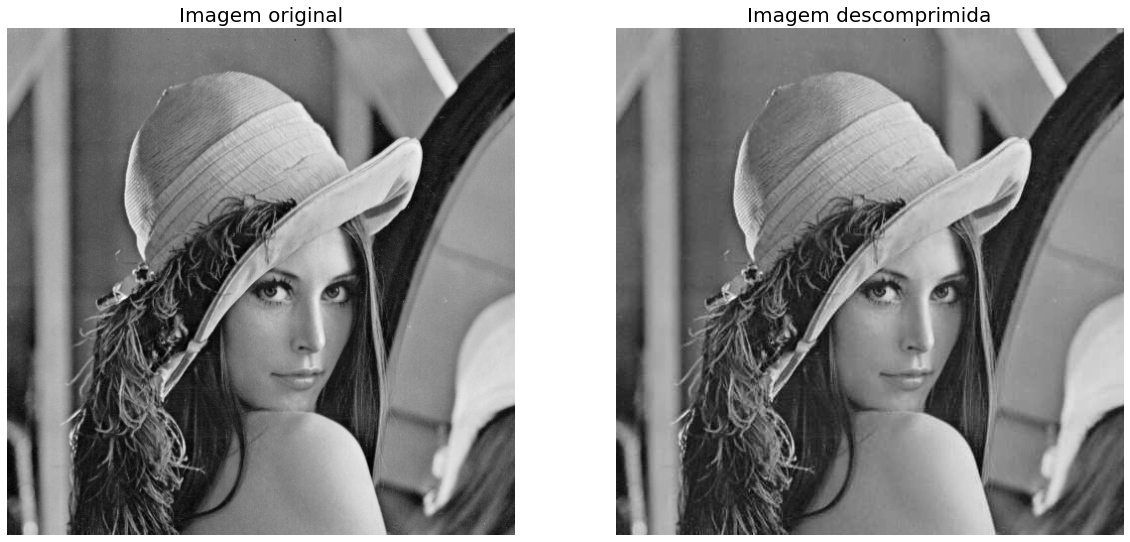

In [39]:
def test_full_compression_and_decompression_algorithms():
    image_path = "images/lena512.pgm"
    compressed_file = "compressed_image.gbpg"
    decompressed_file = "decompressed_image.jpeg"

    full_compression_algorithm(image_path, compressed_file)
    full_decompression_algorithm(compressed_file, decompressed_file)

    original_image = opencv.imread(image_path, opencv.IMREAD_GRAYSCALE)
    decompressed_image = opencv.imread(decompressed_file, opencv.IMREAD_GRAYSCALE)

    show_images({"Imagem original": original_image, "Imagem descomprimida": decompressed_image})

test_full_compression_and_decompression_algorithms()

## Testes e Resultados
Nesta seção, a imagem `lena512.pgm` será utilizada para testar o algoritmo completo de compressão e descompressão de imagens, fazendo a avaliação da qualidade da compressão com as métricas **RMSE** e **PSNR**, além do cálculo da taxa de compressão.

O módulo `os` será utilizado para verificar o tamanho dos arquivos gerados, permitindo calcular a taxa de compressão de forma prática.

In [40]:
import os

def assess_full_algorithm_compression_quality() -> None:
    image_path = "images/lena512.pgm"
    compressed_file = "compressed_image.gbpg"
    decompressed_file = "decompressed_image.jpeg"

    full_compression_algorithm(image_path, compressed_file)
    full_decompression_algorithm(compressed_file, decompressed_file)

    original_image = opencv.imread(image_path, opencv.IMREAD_GRAYSCALE)
    decompressed_image = opencv.imread(decompressed_file, opencv.IMREAD_GRAYSCALE)

    original_size = os.stat(image_path).st_size
    # compressed_size = os.stat(compressed_file).st_size
    decompressed_size = os.stat(decompressed_file).st_size

    print(f"Erro Quadrático Médio (MSE): {mse(decompressed_image, original_image)}")
    print(f"Raiz do Erro Quadrático Médio (RMSE): {rmse(decompressed_image, original_image)}")
    print(f"Taxa de Pico de Sinal para Ruído (PSNR): {psnr(decompressed_image, original_image)}")
    print(f"Tamanho da imagem original: {original_size} bytes")
    print(f"Tamanho da imagem após compressão e descompressão: {decompressed_size} bytes")
    print(f"Taxa de compressão: {original_size / decompressed_size}")

assess_full_algorithm_compression_quality()

Erro Quadrático Médio (MSE): 15.29792
Raiz do Erro Quadrático Médio (RMSE): 3.91126
Taxa de Pico de Sinal para Ruído (PSNR): 36.28447
Tamanho da imagem original: 262178 bytes
Tamanho da imagem após compressão e descompressão: 48050 bytes
Taxa de compressão: 5.456357960457856
